# What are Word2Vec embeddings?

It is hard to explain Word Embeddings better than Andrew Ng, here is a great video: https://www.coursera.org/lecture/nlp-sequence-models/word2vec-8CZiw. Basically, we turn 'words' into 'vectors of numbers' to make data scientists happy... and more importantly to pave the way for using advanced algorithms and extract useful insights from text! Here we will use Google's Word2Vec word embeddings (300 dimensional vectors).

# Approach for testing Word2Vec

What does English language look like if we print it on a 2D map; a clustering based on Word2Vec embeddings? Depending on the quality of the clusters (how much we are able to understand their meaning) we would be able to say 'Word2Vec describes language very well' or 'No Word2Vec is not reliable enough'. To be fair, this clustering actually will test how the model captures 'similarities' (syntagmatic and paradigmatic relations) rather then linear compositions (see the famous example below).

There are lots of great examples such as 'Queen = King + Woman - Man' illustrating how the model is good. We explore here a systematic testing on (almost) all English language in order to be able to assess the 'overall picture'.

# Suggested test = Clustering of 300k words on top on SOM applied to Word2Vec coordinates then assess cluster 'interpretability'

## Step 1 - Loading Word2Vec vectors

First we install gensim package and load Word2Vec model
Source: https://code.google.com/archive/p/word2vec/ 
SLIM version, (300k words instead of 3m): https://github.com/eyaler/word2vec-slim

In [ ]:
!pip install gensim
import gensim
from gensim.models import Word2Vec
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleW2VModel/GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

Quick tests on Word2Vec:

In [14]:
print('The famous test: woman + king - man = (should be ~Queen)')
print(model.most_similar(positive=['woman', 'king'], negative=['man']))
print('Similarity measure between man and woman')
print(model.similarity('woman', 'man'))

The famous test: woman + king - man = (should be ~Queen)
[('queen', 0.7118192911148071), ('monarch', 0.6189674735069275), ('princess', 0.5902431607246399), ('prince', 0.5377322435379028), ('kings', 0.5236844420433044), ('queens', 0.5181134343147278), ('sultan', 0.5098593235015869), ('monarchy', 0.5087411999702454), ('throne', 0.5005807280540466), ('royal', 0.4938204884529114)]
Similarity measure between man and woman
0.7664013


C:\Users\Samir A Ghoudrani\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [15]:
## Let's assess the size and convert to DF
## print(model.vectors.shape) ## (299567, 300)
import pandas as pd
Words_Vectors = pd.DataFrame(model.vectors)
print(Words_Vectors.shape)
Words_Vectors.head()

(299567, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.052956,0.065460,0.066195,0.047072,0.052221,-0.082009,-0.061415,-0.116210,0.015629,0.099293,...,-0.127242,-0.066931,-0.060679,0.048911,0.046153,-0.035672,-0.044314,-0.035856,0.010895,-0.047072
1,-0.008512,-0.034224,0.032284,0.045868,-0.013143,-0.046221,-0.000948,-0.052219,0.046574,0.062451,...,-0.016318,0.002690,-0.059628,0.058923,0.005733,0.000345,0.013319,0.051513,-0.025227,0.017465
2,-0.012361,-0.022230,0.065540,0.039477,-0.086620,0.024913,-0.011163,-0.070522,0.092369,0.092752,...,-0.008863,-0.012265,-0.026254,-0.016193,-0.015235,0.050209,0.015810,0.005390,0.047909,-0.116515
3,0.003746,-0.038920,0.091332,0.012000,-0.070575,0.105343,0.059936,-0.057342,0.038141,0.011092,...,-0.124024,-0.019330,-0.049817,0.097040,0.014400,0.067980,-0.013168,0.005968,0.087180,0.056823
4,0.016681,-0.056670,0.017367,0.127356,0.003885,-0.056366,0.014091,-0.100544,0.082873,0.038085,...,0.016757,-0.017443,0.019271,0.025288,-0.081654,0.051796,0.009826,-0.072819,-0.018357,-0.044179


In [16]:
## Let's get the words list
print(len(model.vocab)) ## 299567
type(model.vocab)
words = pd.DataFrame.from_dict(model.vocab, orient='index', columns=['words']).index

299567


## Step 2 - Clustering with SOM: 900 nodes

Let's use Python's Sompy package for SOM: Self-Organising Maps

In [ ]:
##!pip install sompy
!pip install git+https://github.com/compmonks/SOMPY.git
!pip install ipdb==0.8.1
import sompy
from sompy.sompy import SOMFactory

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

We define the number of nodes in our SOM map:

In [29]:
mapsize = [30,30]

We build the model, hyperparameters can be tuned for better results:

In [ ]:
som = sompy.SOMFactory.build(model.vectors, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  

We specify and start the training (1 epoch corresponds to a full iteration on all the data):

In [ ]:
som.train(n_job=1, train_rough_len=50, train_finetune_len=50)  # verbose='debug' will print more, and verbose=None wont print anything

Let's measure the SOM Quality from a mathematical point of view:

In [19]:
topographic_error = som.calculate_topographic_error() ## Quality of the map itself, SOM nodes themselves
quantization_error = np.mean(som._bmu[1]) ## Quality of the affectation of our observations to each node in the SOM map
print('Topographic error = %s; Quantization error = %s' % (topographic_error, quantization_error))

Topographic error = 0.6077571962198773; Quantization error = 14.994358276286036


Heat Map of the number of observations per node: is the map balanced? (homogeneous usage?)

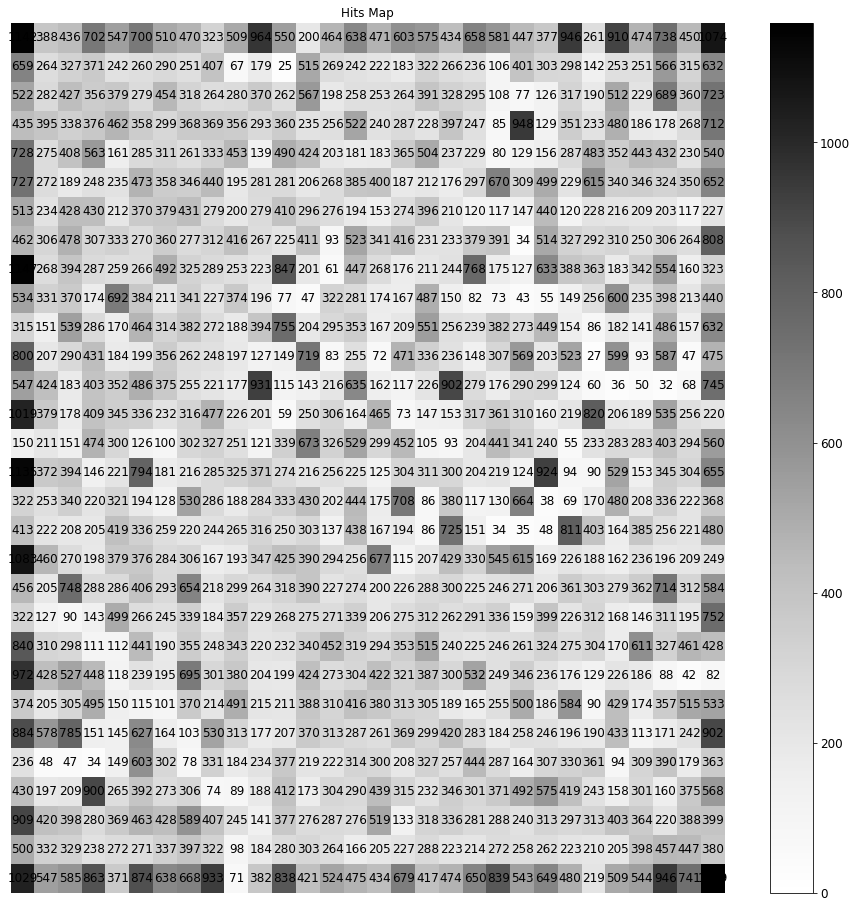

In [20]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

We can view windows with the projected heatmap / by dimension: (not needed here)

In [ ]:
colnames = list(Words_Vectors.columns.values)
som.component_names = colnames
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

## Step 3 - K-Means clustering on Top of SOM: 100 clusters

In [22]:
## Let's do clustering (K-means by default) on top of the trained som
v = sompy.mapview.View2DPacked(2, 2, 'test',text_size=8)  

map_labels = som.cluster(n_clusters=100)
data_labels = np.array([map_labels[int(k)] for k in som._bmu[0]]) # mapping labels from grid to original data
print(data_labels.shape)
data_labels

(299567,)


array([26, 90, 90, ..., 17, 68, 17])

Visualisation of clusters:

C:\Users\Samir A Ghoudrani\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


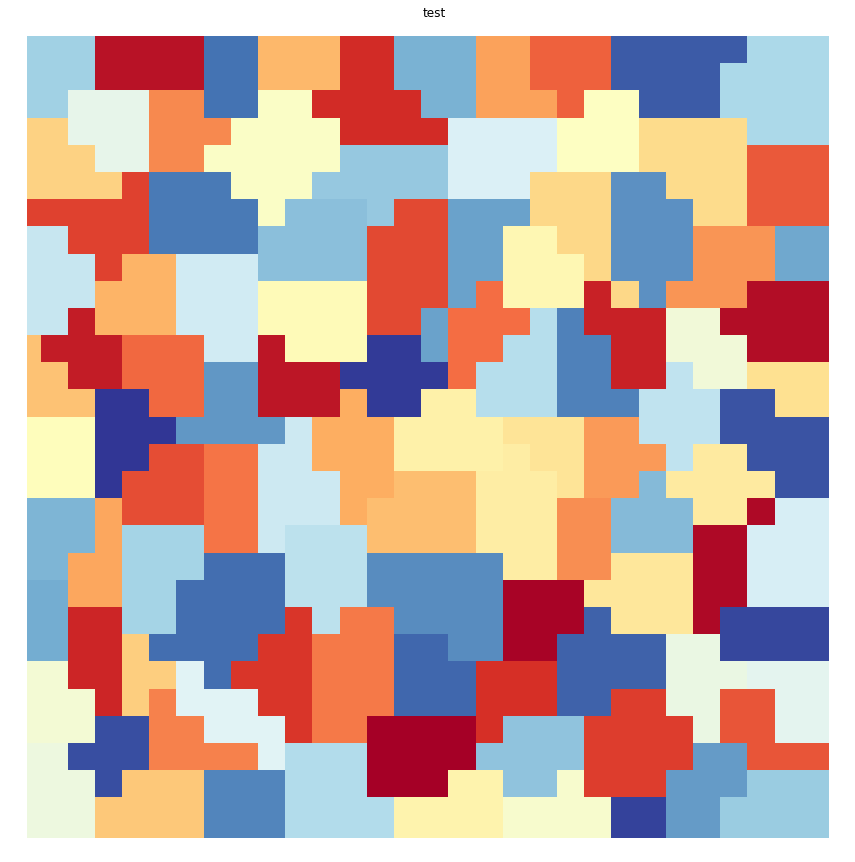

In [23]:
v.show(som, what='cluster')

Visualisation of cluster IDs on top of the SOM map:

C:\Users\Samir A Ghoudrani\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


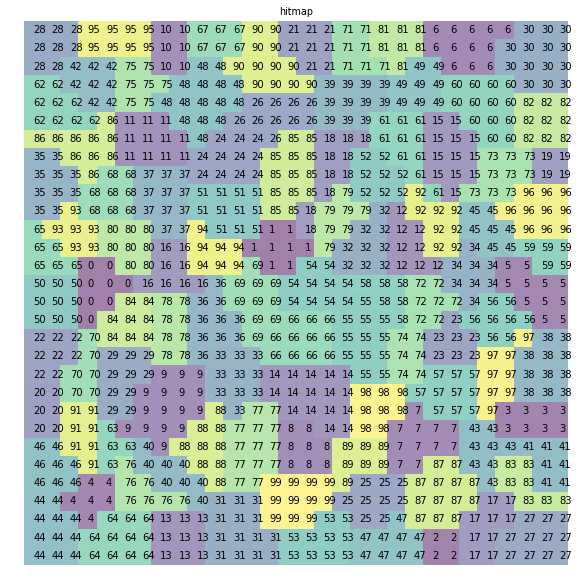

array([[  0,   0,   0],
       [  0,   1,   1],
       [  0,   2,   2],
       ...,
       [ 29,  27, 897],
       [ 29,  28, 898],
       [ 29,  29, 899]])

In [24]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

Let's build the mapping: Word - Cluster (2 column DF):

In [37]:
len(words) ## 299567
len(data_labels) ## 299567

words_in_clusters = pd.DataFrame(np.column_stack([words, data_labels]), 
                               columns=['Word', 'Cluster'])

words_in_clusters.head()

,Word,Cluster
0,in,26
1,for,90
2,that,90
3,is,67
4,on,26


# Do the clusters make sense? (see infographic)

## Check yourself by setting 'Cluster_to_look_into' between 0 and 99

Now let's check our clusters!
Do they make sense?
Let's look into each cluster and try to figure out what it is about:

In [34]:
Cluster_to_look_into = 25

Important to keep in mind: the order of words here is still the Google model's order (by frequency in common language use) 

In [35]:
words_in_clusters[words_in_clusters['Cluster']==Cluster_to_look_into].head(50)

## We can now try all values from 0 to Number_clusters!
## =============> Results in the infographic in this repository :)

,Word,Cluster
215,group,25
226,program,25
316,community,25
404,National,25
429,project,25
531,research,25
539,Center,25
647,annual,25
685,programs,25
712,education,25


## Check our results in the infographic (in this repo)

Important: there is a fair part of randomisation in SOM algorithm, please keep in mind the clusters Ids can change after you run this notebook on your computer.